# Итоговая работа по курсу "Работа аналитика в команде"

## Датасет - база заказов онлайн магазина из Великобритании.
- InvoiceNo - номер товарной накладной/заказа
- Stock code - номер товара в складском учете (уникальный)
- Description - описание операции
- Quantity - кол-во товара
- InvoiceDate - дата заказа
- Unit price - цена за единицу
- CustomerID - id покупателя
- Country - страна заказа

### Импортируем библиотеки

In [139]:
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 15,12

import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
import statistics

%matplotlib inline

### Загружаем датасет

In [140]:
df = pd.read_csv('Data.csv')

### Смотрим общую информацию, пример данных, качество

In [141]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/10 8:26,"3,39",17850.0,United Kingdom
1,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/10 8:34,"1,69",13047.0,United Kingdom
2,536367,21755,LOVE BUILDING BLOCK WORD,3,12/1/10 8:34,"5,95",13047.0,United Kingdom
3,536368,22914,BLUE COAT RACK PARIS FASHION,3,12/1/10 8:34,"4,95",13047.0,United Kingdom
4,536373,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 9:02,"2,75",17850.0,United Kingdom


In [142]:
df.describe()

,Quantity,CustomerID
count,54214.000000,40643.000000
mean,9.610802,15283.422803
std,57.358422,1707.982278
min,-9600.000000,12347.000000
25%,1.000000,13969.000000
50%,3.000000,15152.000000
75%,10.000000,16775.000000
max,2400.000000,18287.000000


In [143]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54214 entries, 0 to 54213
Data columns (total 8 columns):
InvoiceNo      54214 non-null object
StockCode      54214 non-null object
Description    54080 non-null object
Quantity       54214 non-null int64
InvoiceDate    54214 non-null object
UnitPrice      54214 non-null object
CustomerID     40643 non-null float64
Country        54214 non-null object
dtypes: float64(1), int64(1), object(6)
memory usage: 3.3+ MB


#### Видим, что не у всех товаров есть описание, отсутствует 134 записи. Также не по всем заказам есть CustomerID. В количестве есть отрицательные значения с минимальным - 9600. Больше похожие на ошибки данных, с учетом квартилей на уровне 1, 3 и 10

In [169]:
#проверим описание для записей без CustomerID для положительных и отрицательных значений Quantity
#положительные
df[(df.CustomerID.isnull())&(df.Quantity > 0)].groupby(['Description'])['Description'].count().sort_values(ascending = False).head(10)

Description
DOTCOM POSTAGE                       72
JUMBO BAG RED RETROSPOT              49
JUMBO SHOPPER VINTAGE RED PAISLEY    45
JUMBO BAG WOODLAND ANIMALS           43
JUMBO BAG APPLES                     40
JUMBO STORAGE BAG SUKI               40
JUMBO  BAG BAROQUE BLACK WHITE       38
CHARLOTTE BAG SUKI DESIGN            36
GREEN REGENCY TEACUP AND SAUCER      36
JUMBO BAG PINK POLKADOT              36
Name: Description, dtype: int64

In [166]:
#отрицательные
df[(df.CustomerID.isnull())&(df.Quantity <= 0)].groupby(['Description'])['Description'].count().sort_values(ascending = False).head(10)

Description
check                     7
POSTAGE                   7
SAMPLES                   6
damaged                   4
damages                   3
Unsaleable, destroyed.    2
AMAZON FEE                2
sold as set on dotcom     2
Bank Charges              2
Damaged                   2
Name: Description, dtype: int64

#### Видим много технических записей вроде почтовых расходов, комиссий амазона, списаний брака и пр по которым нужно будет вести отдельную статистику

### Изучим описание покупок

Количество записей с отрицательными значениями -  1057


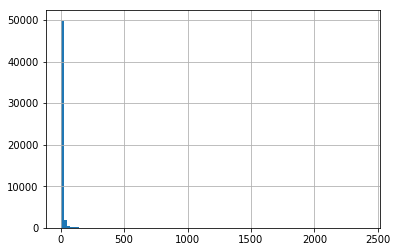

In [179]:
#Количество записей с положительными значениями
print('Количество записей с отрицательными значениями - ',df.Quantity[df.Quantity < 0].count())
#визуализируем гистрограмму распределения положительных значений
df.Quantity[df.Quantity > 0].hist(bins = 100)

In [180]:
#проверим описание положительных сумм по частоте
df[df.Quantity > 0].groupby(['Description'])['Quantity'].count().sort_values(ascending=False).head()

Description
WHITE HANGING HEART T-LIGHT HOLDER    239
JUMBO BAG RED RETROSPOT               219
REGENCY CAKESTAND 3 TIER              182
LUNCH BAG RED RETROSPOT               167
PACK OF 72 RETROSPOT CAKE CASES       161
Name: Quantity, dtype: int64

Количество записей с отрицательными значениями -  1083


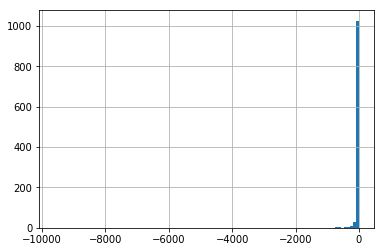

In [144]:
#Количество записей с отрицательными значениями
print('Количество записей с отрицательными значениями - ',df.Quantity[df.Quantity < 0].count())
#визуализируем гистрограмму распределения отрицательных значений
df.Quantity[df.Quantity < 0].hist(bins = 100)

In [145]:
#проверим описание отрицательных сумм по частоте
df[df.Quantity < 0].groupby(['Description'])['Quantity'].count().sort_values(ascending=False).head()

Description
Manual                             26
REGENCY CAKESTAND 3 TIER           22
POSTAGE                            14
Discount                           13
RECIPE BOX PANTRY YELLOW DESIGN    10
Name: Quantity, dtype: int64

In [146]:
#видим учебные записи Manual, которые исключаем. Остальные записи считаем расходами
df = df[df.Description != 'Manual']

In [147]:
#посмотрим квартили
df.Quantity[df.Quantity < 0].quantile([.1, .25, .5, .75]) 

0.10   -40.0
0.25   -11.0
0.50    -2.0
0.75    -1.0
Name: Quantity, dtype: float64

In [148]:
#проверяем кол-во уникальных заявок
print('Всего записей заявок - ', df.InvoiceNo.count())
print('Уникально заявок - ', df.InvoiceNo.nunique())

Всего записей заявок -  54157
Уникально заявок -  14844


In [149]:
#проверяем кол-во уникальных клиентов
print('Всего записей клиентов - ', df.CustomerID.count())
print('Уникально клиентов - ', df.CustomerID.nunique())

Всего записей клиентов -  40595
Уникально клиентов -  3818


In [150]:
#проверяем кол-во уникальных стран
print('Всего записей стран - ', df.Country.count())
print('Уникально стран - ', df.Country.nunique())


Всего записей стран -  54157
Уникально стран -  37


In [151]:
#создаем колонку с объемом заявки по StockCode
df['UnitPrice'] = df['UnitPrice'].str.replace(',', '.').astype(float)
df['volume'] = df.UnitPrice * df.Quantity
#выделяем дату
df['date'] = df['InvoiceDate'].str.split(' ').str[0]
df['time'] = df['InvoiceDate'].str.split(' ').str[-1]
df['date'] = pd.to_datetime(df['date'])
#pd.to_datetime(df['date'], format='%d%m%Y', errors='ignore')

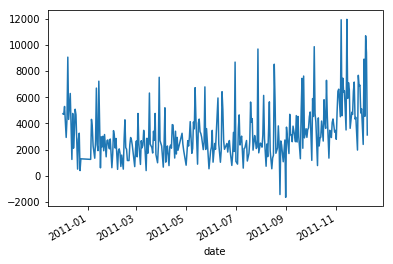

In [152]:
#посмотрим на динамику продаж по дням
df_date_volume = df.groupby('date')['volume'].sum()
df_date_volume.plot()

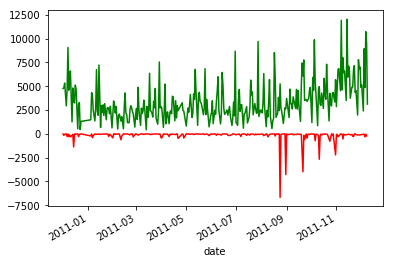

In [348]:
#посмотрим на динамику продаж по доходам-расходам
df[df.volume > 0].groupby('date')['volume'].sum().plot(color='green')
df[df.volume < 0].groupby('date')['volume'].sum().plot(color='red')

#### На графике видно рост продаж к новогодним и рождественнским праздникам, тематические покупки отдельно можно исследовать и прогнозировать

In [193]:
#изучим причины всплесков
df.sort_values(['volume'], ascending= False).head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,volume,date,time
5225,540689,22470,HEART OF WICKER LARGE,1284,1/11/11 8:43,3.21,17450.0,United Kingdom,4121.64,2011-01-11,8:43
53401,581115,22413,METAL SIGN TAKE IT OR LEAVE IT,1404,12/7/11 12:20,2.75,15195.0,United Kingdom,3861.00,2011-12-07,12:20
28245,561633,23173,REGENCY TEAPOT ROSES,384,7/28/11 14:33,8.15,17949.0,United Kingdom,3129.60,2011-07-28,14:33
53996,581457,23543,WALL ART KEEP CALM,698,12/8/11 18:43,4.15,18102.0,United Kingdom,2896.70,2011-12-08,18:43
24465,558526,23174,REGENCY SUGAR BOWL GREEN,696,6/30/11 11:01,3.75,17949.0,United Kingdom,2610.00,2011-06-30,11:01
22639,556725,22783,SET 3 WICKER OVAL BASKETS W LIDS,200,6/14/11 11:28,12.48,18102.0,United Kingdom,2496.00,2011-06-14,11:28
43703,574294,21915,RED HARMONICA IN BOX,2100,11/3/11 15:47,1.06,16333.0,United Kingdom,2226.00,2011-11-03,15:47
20301,554366,22702,BLACK AND WHITE CAT BOWL,888,5/24/11 10:24,2.40,17450.0,United Kingdom,2131.20,2011-05-24,10:24
24463,558526,22699,ROSES REGENCY TEACUP AND SAUCER,768,6/30/11 11:01,2.55,17949.0,United Kingdom,1958.40,2011-06-30,11:01
1612,537657,82484,WOOD BLACK BOARD ANT WHITE FINISH,408,12/7/10 16:42,4.78,18102.0,United Kingdom,1950.24,2010-12-07,16:42


#### два варианта - или большой объем заказа и или дорогие позиции. Также видим, что повторяются покупатели. Т.е. можно еще отслеживать топовых покупателей

In [223]:
#топ по дорогим позициям
df[['Description','UnitPrice']].drop_duplicates().sort_values(['UnitPrice'], ascending = False).head()

,Description,UnitPrice
31245,AMAZON FEE,6662.51
42864,AMAZON FEE,2185.04
50859,DOTCOM POSTAGE,1526.76
48504,DOTCOM POSTAGE,1236.75
51571,DOTCOM POSTAGE,888.42


In [226]:
#исключим расходы на почту
df[['Description','UnitPrice']][(df.Quantity > 0)&(df.Description.str.contains('POSTAGE')  == False)].drop_duplicates().sort_values(['UnitPrice'], ascending = False).head(10)

,Description,UnitPrice
11600,LOVE SEAT ANTIQUE WHITE METAL,195.00
20285,REGENCY MIRROR WITH SHUTTERS,165.00
20284,RUSTIC SEVENTEEN DRAWER SIDEBOARD,165.00
17215,RUSTIC SEVENTEEN DRAWER SIDEBOARD,145.00
10971,VINTAGE BLUE KITCHEN CABINET,125.00
24588,CHEST NATURAL WOOD 20 DRAWERS,125.00
7250,VINTAGE RED KITCHEN CABINET,125.00
25700,CINDERELLA CHANDELIER,99.96
29083,LOVE SEAT ANTIQUE WHITE METAL,85.00
385,VINTAGE POST OFFICE CABINET,79.95


In [227]:
#топ по объемам
df[['Description','Quantity']][(df.Quantity > 0)&(df.Description.str.contains('POSTAGE')  == False)].drop_duplicates().sort_values(['Quantity'], ascending = False).head(10)

,Description,Quantity
9311,ESSENTIAL BALM 3.5g TIN IN ENVELOPE,2400
43703,RED HARMONICA IN BOX,2100
40982,GINGHAM HEART DECORATION,1728
9148,SMALL CHINESE STYLE SCISSOR,1500
28449,GIRLS ALPHABET IRON ON PATCHES,1440
53401,METAL SIGN TAKE IT OR LEAVE IT,1404
5225,HEART OF WICKER LARGE,1284
18749,PACK OF 72 RETROSPOT CAKE CASES,1200
45188,ASSORTED COLOUR BIRD ORNAMENT,1200
37033,CHRISTMAS TOILET ROLL,1200


#### позиции вроде CHRISTMAS TOILET ROLL говорят о сезонных товарах


In [254]:
#топ прибыли по покупателям
df_customers = df[(df.Quantity > 0)&(df.Description.str.contains('POSTAGE')  == False)].groupby(['CustomerID'])['Quantity','volume'].sum().sort_values(['volume'], ascending = False)
df_customers.head(10)

,Quantity,volume
CustomerID,,
18102.0,6587,26533.44
14646.0,20333,25519.16
17450.0,8036,23000.10
12415.0,9565,16102.89
14911.0,8447,13551.28
14156.0,4919,12092.71
17949.0,5528,12048.08
17511.0,6998,9534.21
15769.0,4536,8129.04


Доля доходов от топовых клиентов от всей выручки - 15.15%


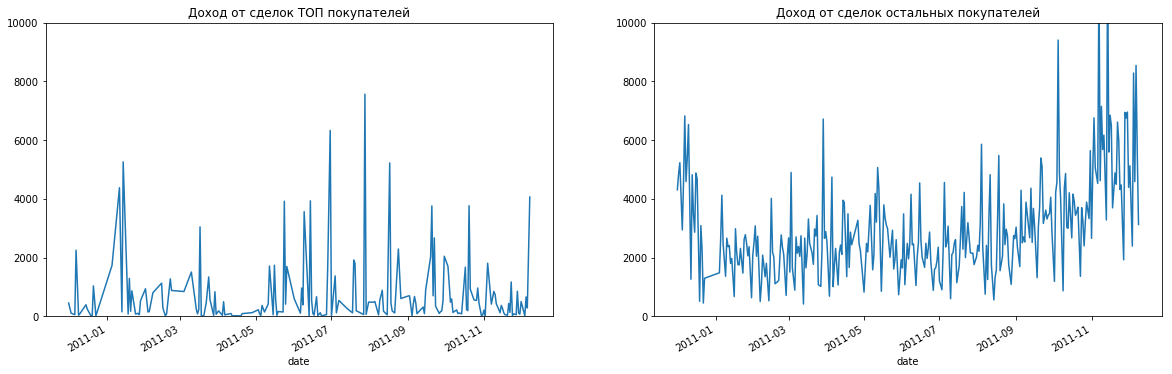

In [319]:
#Построим два графика - выручка от топ 10 покупателей в динамике и по остальным
top_customers = [18102,14646,17450,12418,14911,14156,17949,17511,15769,13694]
print('Доля доходов от топовых клиентов от всей выручки - {:.2%}'.format(df['volume'][(df.CustomerID.isin(top_customers))&(df.Quantity > 0)].sum()/
      df['volume'][(~df.CustomerID.isin(top_customers))&(df.Quantity > 0)].sum()))

plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
plt.ylim(0, 10000)
plt.title('Доход от сделок ТОП покупателей')
df[(df.CustomerID.isin(top_customers))&(df.Quantity > 0)].groupby(['date'])['volume'].sum().plot()
plt.subplot(1,2,2)
plt.ylim(0, 10000)
plt.title('Доход от сделок остальных покупателей')
df[(~df.CustomerID.isin(top_customers))&(df.Quantity > 0)].groupby(['date'])['volume'].sum().plot()
plt.show()

#### Из интересных наблюдейний, пик заказов у топовых покупателей приходится на середину года

      Quantity    volume
0.10      6.70   15.0000
0.25     17.00   32.5200
0.50     44.00   78.0000
0.75    117.25  193.0525


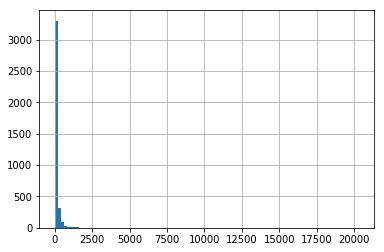

In [261]:
print(df_customers.quantile([.1, .25, .5, .75]))
df_customers.Quantity.hist(bins = 100)

In [263]:
#проверяем еще раз распределение по объему одного заказа
print(df.Quantity.quantile([.1, .25, .5, .75]))

0.10     1.0
0.25     1.0
0.50     3.0
0.75    10.0
Name: Quantity, dtype: float64


#### видим, что разовые заказы совершались меньше чем на 10 позиций за все время. По этому признаку можно разделить покупателей на оптовых и розничных

In [284]:
#Добавляем признак юр лица и физ лица
df['customer_type'] = df.Quantity.apply(lambda x: 'ЮЛ' if abs(x) > 10 else 'ФЛ')

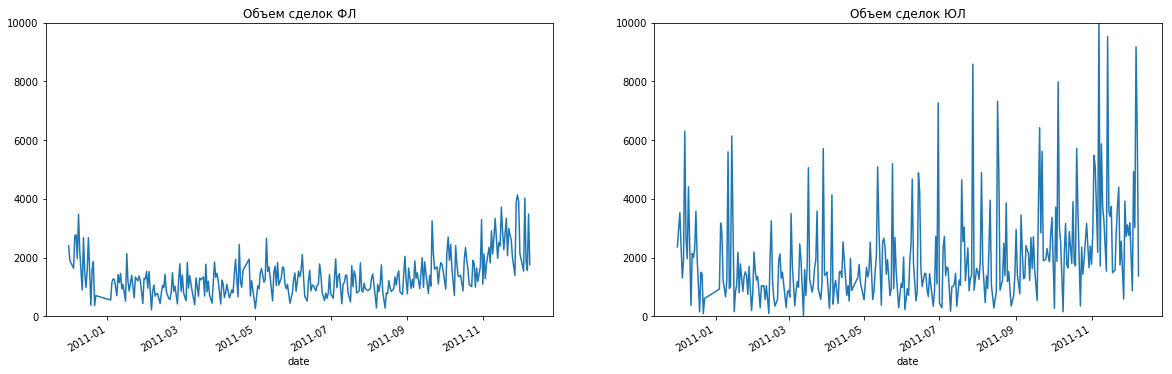

In [297]:
#рисуем график для ФЛ и ЮЛ
plt.figure(figsize=(20,6))

# gender_dynamics
plt.subplot(1,2,1)
plt.ylim(0, 10000)
plt.title('Объем сделок ФЛ')
df[(df.customer_type == 'ФЛ')&(df.Quantity > 0)].groupby(['date'])['volume'].sum().plot()
plt.subplot(1,2,2)
plt.ylim(0, 10000)
plt.title('Объем сделок ЮЛ')
df[(df.customer_type == 'ЮЛ')&(df.Quantity > 0)].groupby(['date'])['volume'].sum().plot()
plt.show()

In [291]:
print('Стандартное отклонение для ФЛ - ',statistics.pstdev(df[df.customer_type == 'ФЛ'].groupby(['date'])['volume'].sum()))
print('Стандартное отклонение для ЮЛ - ',statistics.pstdev(df[df.customer_type == 'ЮЛ'].groupby(['date'])['volume'].sum()))

Стандартное отклонение для ФЛ -  788.9564042148788
Стандартное отклонение для ЮЛ -  1694.332990897328


In [292]:
print('Медиана для ФЛ - ',statistics.median(df[df.customer_type == 'ФЛ'].groupby(['date'])['volume'].sum()))
print('Медиана для ЮЛ - ',statistics.median(df[df.customer_type == 'ЮЛ'].groupby(['date'])['volume'].sum()))

Медиана для ФЛ -  1232.6500000000005
Медиана для ЮЛ -  1516.1000000000001


#### виден разный характер покупок. Для наших ЮЛ характерны периодические крупные покупки,  размах больше

In [174]:
#посмотрим распределение по странам
df.groupby(['Country'])['Country'].count().sort_values(ascending = False).head()

Country
United Kingdom    49557
Germany             949
France              880
EIRE                785
Spain               253
Name: Country, dtype: int64

#### Большая часть покупок совершается из Англии, что логично. По остальным странам можно взять как ключевую метрику для отслеживания расширения и маркетинговых компаний

В среднем ежедневно в магазине делают покупок 42


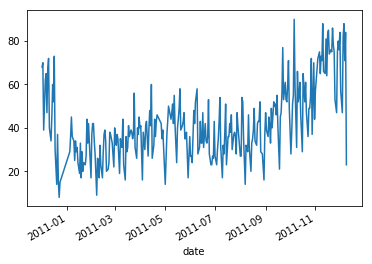

In [313]:
#проверим динамику по кол-ву пользователей ежедневно
df_customers_stats = df[['date','CustomerID']].drop_duplicates()
df_customers_stats.groupby(['date'])['CustomerID'].count().plot()
print('В среднем ежедневно в магазине делают покупок {:.0f} покупателя'.format(statistics.mean(df_customers_stats.groupby(['date'])['CustomerID'].count())))

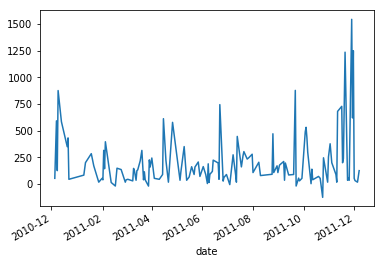

In [339]:
#проверим динамику и размер расходов на почтовые расходы
df[df.Description.str.contains('POSTAGE') == True].groupby(['date'])['volume'].sum().plot()

In [343]:
#и средние расходы на почту в зависимости от стран
df[df.Description.str.contains('POSTAGE') == True].groupby(['Country'])['volume'].mean().sort_values(ascending = False)

Country
United Kingdom    224.658132
Norway            204.900000
Switzerland       173.333333
Malta             160.000000
Finland           120.000000
Portugal           93.333333
Spain              84.000000
Germany            66.882353
France             45.848485
Belgium            43.800000
Sweden             40.000000
Netherlands        30.000000
Denmark            30.000000
Name: volume, dtype: float64

## Описание бизнес-заказчика, его гипотетических болей и целей развития текущего бизнеса

    В качестве датасета мы берем базу онлайн магазина из Великобритании. Мы не знаем, насколько это большой магазин, возможно в датасете лишь часть операций, надо изучить объемы продаж и клиентскую базу. 

    Самые важные показатели, которые должен отслеживать магазин из представленных данных - доход, кол-во клиентов, объемы заказов, топовые клиенты, приносящие бОльшую долю выручки, топовые по спросу позиции.
    
    Боль клиента, которую можно дополнительно решить - место на складе под специфический и сезонный товар. Отслеживание текущих стоков. Учет важных клиентов, с большой долей выручки(уход таких клиентов может сказаться на финансовом состоянии магазина).Каналы привлечения, как текущие продажи разделяются по каналам. Т.е. простроить воронку с момента посещения сайта до совершения сделки. Контролировать завершенные покупки и повторные покупки.Возможные цели клиента, о которых надо подробнее разговаривать с заказчиком и часть которых можно контролировать данными из датасета - выход на новые рынки, новые страны, новые товары. Сокращение издержек, альтернативные варианты доставки товаров, снижение кол-ва брака и возвратов. 
    
    В качестве метрик для дашборда я взял доходы в разрезе ФЛ и ЮЛ, которые помогут контролировать направление работы компании, результаты партнерских договоренностей, состава выручки. На этом же графике расходы, для понимания динамики. Отдельно добавил значение доли расходов к доходам, как некий алерт, и топ 5 статей расходных, для контроля( но для специалистов этот показатель потребует подробной расшифровки и детализации, конечно же). Также мы отслеживаем динамику уникальных клиентов по месяцам и типу клинта, совершающих покупки. Тут хорошо видна сезонность продаж. Верхнеуровнего отслеживаем объем продаж по топу стран, исключая страну, где магазин находится( также для маркетинга это должен быть подробный отчет для отслеживания маркетинговых компаний и продвижения на рынке). В целом отчет получился больше для гендира, он дает общее представление о положении дел в компании. Для финдира также можно подробно разобрать составляющие доходов-расходов. Ну и по мере уточнения и дополнения данных нужно обновлять и дашборд. Например добавить новых клиентов, продажу новых для магазина позиций, воронку реистрации и т.д.

### Конечно же это не все возможные исследования. Множество дополнительных тестов и гипотез можно проверять после уточнения и дополнения данных по итогам первой оценки качества и наполнения.